In [1]:
import torch
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from models.depth_model import StereoDepthNet as DepthNetwork

In [2]:
import argparse
args = argparse.ArgumentParser()

args.image_height = 192
args.image_width = 320
args.working_resolution = (args.image_width, args.image_height)
args.use_gt_poses = False
args.use_gray_scale = False
args.use_stereo = True
args.seq_length = 1
args.stride = 1
args.use_multi_scale_images = False
args.undistort = False
args.use_full_res = False
args.use_seq = False
args.use_pose = False
args.batch_size = 1
args.split = "train"
args.learning_rate = 1e-4
args.dataset = "robotcar"
from datasets.robotcar.day_night_paried_dataset import (
    DayNightDataset as RobotCarDataset,
)
args.data_path = "/hdd1/madhu/data/robotcar"  # /2014-12-16-18-44-24/stereo/"
dataset = RobotCarDataset(args)
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=8,
        pin_memory=True,
        sampler=None,
    )


In [3]:
depth_net = DepthNetwork(args, reg_refine=False)
depth_net.cuda()
depth_net.train()

Using cache found in /home/madhu/.cache/torch/hub/facebookresearch_dino_main


StereoDepthNet(
  (model): UniMatch(
    (projector): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (transformer): FeatureTransformer(
      (layers): ModuleList(
        (0-5): 6 x TransformerBlock(
          (self_attn): TransformerLayer(
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (merge): Linear(in_features=128, out_features=128, bias=False)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (cross_attn_ffn): TransformerLayer(
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_feature

In [20]:
for data in dataloader:break

In [21]:
night_frame = data['frame0']
day_frame = data['frame1']

n_left = night_frame['image'].cuda()
n_right = night_frame['stereo_pair'].cuda()

d_left = day_frame['image'].cuda()
d_right = day_frame['stereo_pair'].cuda()

In [22]:
def imshow(image:torch.tensor):
    np_image = image.squeeze().cpu().numpy()
    np_image = np.transpose(np_image, (1,2,0))
    plt.imshow(np_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [23]:
left_features = depth_net.model.extract_feature(n_left, d_left)

In [8]:
#need to pca these and get the top 3 features

night_feat, day_feat = left_features

night_corse_feat = night_feat[0].flatten(2).permute(0,2,1).squeeze()
day_corse_feat = day_feat[0].flatten(2).permute(0,2,1).squeeze()

night_corse_feat = night_corse_feat.cpu().numpy()
day_corse_feat = day_corse_feat.cpu().numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
night_corse_feat = pca.fit_transform(night_corse_feat)
day_corse_feat = pca.fit_transform(day_corse_feat)




In [ ]:
night_feat = night_corse_feat.transpose(1,0).reshape(2,24,40)
day_feat = day_corse_feat.transpose(1,0).reshape(2,24,40)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(night_feat[0])
ax[0,1].imshow(day_feat[0])
ax[1,0].imshow(night_feat[1])
ax[1,1].imshow(day_feat[1])


plt.tight_layout()
plt.show()

In [31]:
def featshow(feature:torch.tensor):
    np_feat = feature.squeeze().detach().cpu().numpy()
    plt.imshow(np_feat[2], cmap='plasma')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

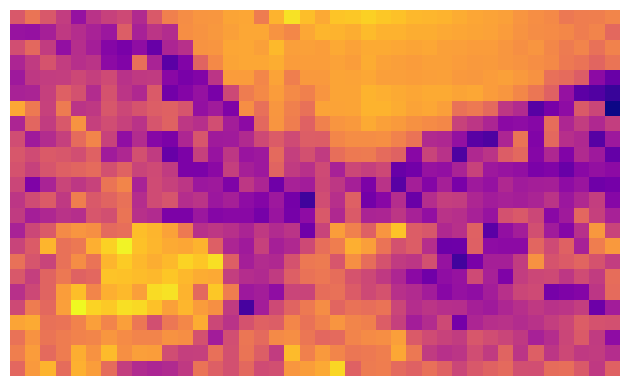

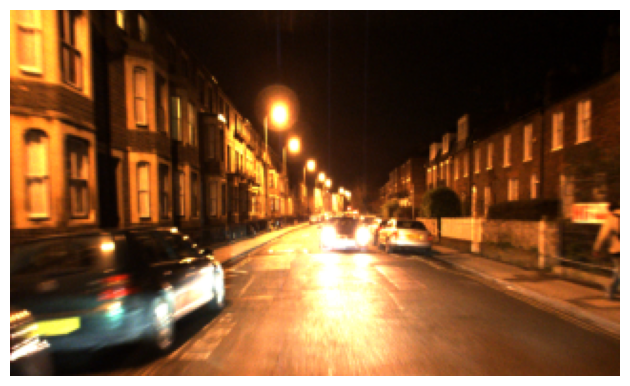

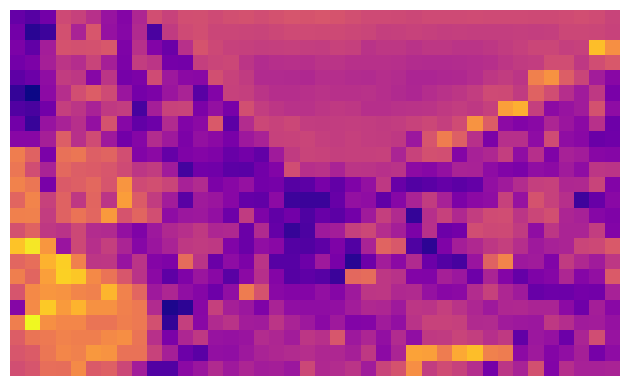

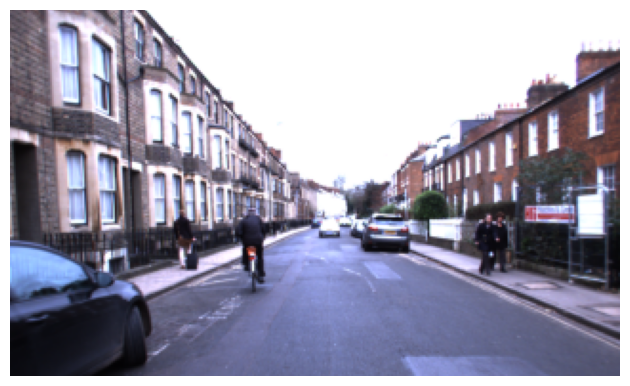

In [24]:
featshow(left_features[0][0])
imshow(n_left[0])
featshow(left_features[1][0])
imshow(d_left[0])

In [16]:
checkpoint_path = "/mnt/nas/madhu/data/checkpoints/chapter_4_cvpr/dino_v1_d_n_2/depth_net_10.pth"
depth_net.load_state_dict(torch.load(checkpoint_path), strict=False)

_IncompatibleKeys(missing_keys=['model.predictor.0.weight', 'model.predictor.0.bias', 'model.predictor.1.weight', 'model.predictor.1.bias', 'model.predictor.1.running_mean', 'model.predictor.1.running_var', 'model.predictor.3.weight', 'model.predictor.3.bias'], unexpected_keys=[])

In [25]:
night_feat = left_features[0]
day_feat = left_features[1]

proj_night_coarse_feat = depth_net.model.projector(night_feat[0])
proj_day_coarse_feat = depth_net.model.projector(day_feat[0])


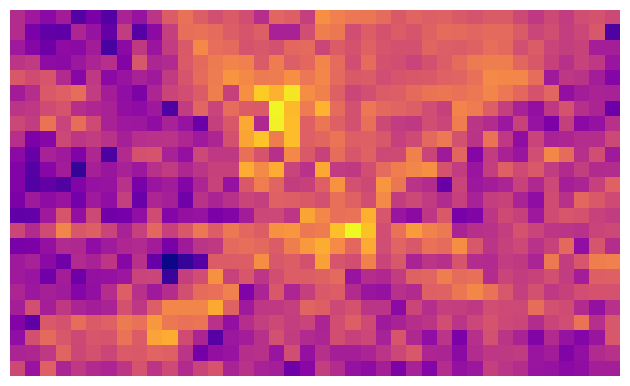

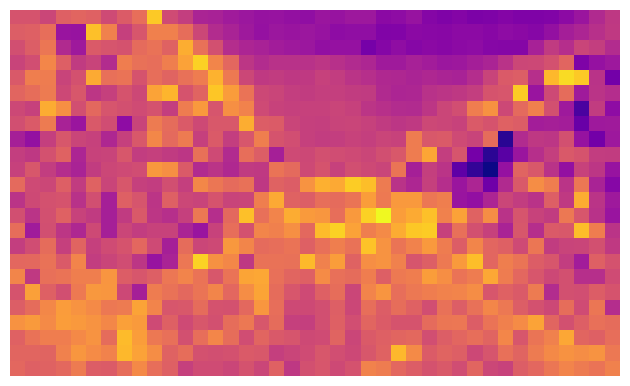

In [32]:
proj_day_coarse_feat.shape

featshow(proj_night_coarse_feat)
featshow(proj_day_coarse_feat)